In [1]:
import dreams.utils.spectra as su
from bertviz import head_view, model_view
import torch
import random
import pandas as pd
import plotly.express as px
import molplotly
import torch
torch.set_printoptions(sci_mode=False)
import umap
from collections import Counter
import seaborn as sns
import dreams.utils.data as du
import dreams.utils.mols as mu
from rdkit import Chem
from tqdm import tqdm
import dreams.utils.dformats as dformats
from dreams.definitions import NIST20, PRETRAINED, MONA
from dreams.utils.dformats import DataFormatA
from dreams.models.dreams.dreams import DreaMS, get_embeddings
from dreams.utils.mols import formula_to_dict
import dreams.utils.plots as plots
import dreams.utils.data as du
import dreams.api as api
from dreams.definitions import *
plots.init_plotting()
%load_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
# msdata = du.MSData.from_pickle(MONA / 'mona_clean_A.pkl', spec_col='PARSED PEAKS', prec_mz_col='PRECURSOR M/Z', adduct_col='ADDUCT', charge_col='CHARGE', smiles_col='SMILES')
# msdata = du.MSData.load(MONA / 'mona_clean_A.hdf5')

In [3]:
msdata = du.MSData.load('../../data/MassSpecGym_DreaMS_rand_100k.hdf5', in_mem=False)
msdata
# embs = msdata['DreaMS_embedding']
# embs.shape

MSData(pth=../../data/MassSpecGym_DreaMS_rand_100k.hdf5, in_mem=False) with 100,000 spectra.

In [4]:
# random.seed(42)
# idx = random.sample(range(len(msdata)), 1000)
# msdata = msdata.form_subset(idx, out_pth='../../data/MassSpecGym_DreaMS_rand_1000.hdf5')

In [5]:
# embs, attns = api.dreams_intermediates(
#     model=PRETRAINED / 'ssl_model.ckpt',
#     msdata=msdata,
#     batch_size=16,
#     tqdm_batches=True,
#     attention_matrices=True,
#     layers_idx=list(range(7))
# )

dataset = msdata.to_torch_dataset(du.SpectrumPreprocessor(
        dformat=dformats.DataFormatA(),
        n_highest_peaks=60
))

In [6]:
attns = msdata['max_attn'][:]
attns.shape

(100000, 61, 61)

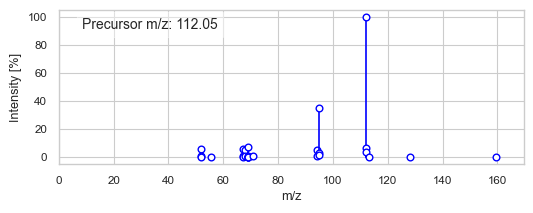

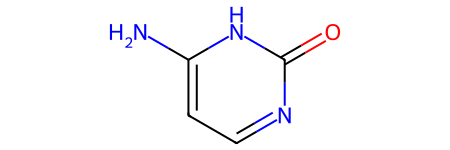

{'COLLISION_ENERGY': nan,
 'DreaMS_embedding': array([ 0.18978249, -0.8088552 , -1.1509975 , ...,  0.06109009,
         1.0084494 ,  0.564358  ], dtype=float32),
 'FOLD': 'train',
 'FORMULA': 'C4H5N3O',
 'IDENTIFIER': 'MassSpecGymID0008672',
 'INCHIKEY': 'OPTASPLRGRRNAP',
 'INSTRUMENT_TYPE': 'Orbitrap',
 'PARENT_MASS': 111.042724,
 'PRECURSOR_FORMULA': 'C4H6N3O',
 'SIMULATION_CHALLENGE': 'False',
 'adduct': '[M+H]+',
 'max_attn': array([[0.97972727, 0.07753959, 0.06808393, ..., 0.0230621 , 0.0230621 ,
         0.0230621 ],
        [0.68767405, 0.42492697, 0.06446894, ..., 0.01987411, 0.01987411,
         0.01987411],
        [0.59290946, 0.28137976, 0.0668726 , ..., 0.01964573, 0.01964573,
         0.01964573],
        ...,
        [0.01639344, 0.01639344, 0.01639344, ..., 0.01639344, 0.01639344,
         0.01639344],
        [0.01639344, 0.01639344, 0.01639344, ..., 0.01639344, 0.01639344,
         0.01639344],
        [0.01639344, 0.01639344, 0.01639344, ..., 0.01639344, 0.01639344,


In [7]:
# i = 2  #   ([67.02880096435547, 0.05455465242266655], 0.2701773941516876),
i = 2
gymid = msdata['IDENTIFIER'][i]
msdata.at(i)

In [8]:
import json
import networkx as nx
import matplotlib.pyplot as plt

with open(f'../../data/trees_with_test_split/{gymid}.json', 'r') as f:
    tree = json.load(f)

def parse_fragmentation_tree(tree):
    G = nx.DiGraph()

    # Add root attributes
    root_attrs = {key: value for key, value in tree.items() if key not in ['fragments', 'losses']}
    G.graph.update(root_attrs)

    # Add nodes (fragments)
    for fragment in tree['fragments']:
        G.add_node(fragment['id'], **fragment)

    # Add edges (losses)
    for loss in tree['losses']:
        G.add_edge(loss['source'], loss['target'], **loss)

    return G

def plot_tree(G):

    # Create a hierarchical layout using a custom approach
    def hierarchical_layout(G, root=0, width=1., height=1.):
        def _layout(G, node, pos, x=0, y=0, dx=1, layer=0):
            children = list(G.successors(node))
            if not children:
                pos[node] = (x, y)
                return
            nx = len(children)
            for i, child in enumerate(children):
                _layout(G, child, pos, x + dx * i / nx, y - height, dx / nx, layer + 1)
            pos[node] = (x + dx / 2, y)

        pos = {}
        _layout(G, root, pos, 0, 0, width, 0)
        return pos

    # Create a hierarchical layout
    pos = hierarchical_layout(G)

    # Set up the figure with a larger size and a light background
    plt.figure(figsize=(10, 5))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Draw the graph
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)  # Reduced node size from 3000 to 1500

    # Add node labels with mz values
    labels = {node: f"m/z: {data['mz']:.2f}\nInt: {data['relativeIntensity']:.2f}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)  # Reduced font size from 10 to 8 to fit smaller nodes

    # Add edge labels with molecular formulas
    edge_labels = nx.get_edge_attributes(G, 'molecularFormula')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Remove axis
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [9]:
import pandas as pd
import numpy as np


# def get_attn(i):
#     spec = dataset[i][SPECTRUM].T
#     n_peaks = (spec[0] != 0).sum()
#     attn = np.zeros((len(attns), attns[0].shape[1], n_peaks, n_peaks))
#     for l in range(len(attns)):
#         attn[l] = attns[l][i, :, :n_peaks, :n_peaks].detach().numpy()
#     return attn

def get_max_attn(i):
    return attns[i]
    # spec = dataset[i][SPECTRUM].T
    # n_peaks = (spec[0] != 0).sum()

    # max_attention = np.zeros((n_peaks, n_peaks))
    # for l in attns.keys():
    #     for h in range(attns[l].shape[1]):
    #         max_attention = np.maximum(max_attention, attns[l][i, h, :n_peaks, :n_peaks].detach().numpy())
    
    # return max_attention


def construct_edge_attn_df(G, i, max_attention):

    spec = dataset[i][SPECTRUM].T
    prec_mz = dataset[i][PRECURSOR_MZ]

    # Create a mapping of m/z values to indices
    mz_to_index = {mz: idx for idx, mz in enumerate(spec[0]) if mz != 0 and (abs(mz - prec_mz) > 1e-2 or idx == 0)}

    # Create a list to store the data for each edge
    edge_data = []

    for e in G.edges:
        # Get the m/z values for the source and target nodes
        source_mz, target_mz = G.nodes[e[0]]['mz'], G.nodes[e[1]]['mz']

        # Find the closest m/z values in our spectrum
        source_idx = min(mz_to_index.keys(), key=lambda x: abs(x - source_mz))
        target_idx = min(mz_to_index.keys(), key=lambda x: abs(x - target_mz))
        
        # Get the corresponding indices
        source_idx = mz_to_index[source_idx]
        target_idx = mz_to_index[target_idx]
        
        # Get the intensity values
        source_intensity = spec[1][source_idx]
        target_intensity = spec[1][target_idx]
        
        # Calculate max attention for this edge
        edge_max_attention = max(max_attention[source_idx, target_idx], max_attention[target_idx, source_idx])
        
        # Append the data for this edge to the list
        edge_data.append({
            'source_node': e[0],
            'target_node': e[1],
            'source_mz': source_mz,
            'target_mz': target_mz,
            'mapped_source_mz': spec[0][source_idx],
            'mapped_target_mz': spec[0][target_idx],
            'source_intensity': source_intensity,
            'target_intensity': target_intensity,
            'max_attention': edge_max_attention
        })

    # Create a DataFrame from the collected data
    edge_df = pd.DataFrame(edge_data)

    return edge_df

def randomization_test(edge_attentions, overall_attention, n_iterations=1000):
    observed_diff = np.mean(edge_attentions) - np.mean(overall_attention)
    n_edge = len(edge_attentions)
    
    random_diffs = []
    for _ in range(n_iterations):
        # Randomly sample from overall_attention
        random_sample = np.random.choice(overall_attention, size=n_edge, replace=False)
        random_diff = np.mean(random_sample) - np.mean(overall_attention)
        random_diffs.append(random_diff)
    
    # Calculate p-value
    p_value = np.mean(np.abs(random_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value, random_diffs

def run_randomization_test(edge_attentions, overall_attention, n_iterations=1000, ci_level=0.95):
    observed_diff, p_value, random_diffs = randomization_test(edge_attentions, overall_attention, n_iterations)

    # Calculate confidence interval
    alpha = 1 - ci_level
    ci_lower, ci_upper = np.percentile(random_diffs, [alpha/2 * 100, (1 - alpha/2) * 100])

    return np.mean(edge_attentions), np.mean(overall_attention), p_value, ci_lower, ci_upper

def accuracy_at_k(G, spec, max_attention, k=10):
    """Compute the accuracy at k when considering the retrieval of edges using the max attention matrix"""
    # Get the true edges for the current node
    true_mzs = set(str(round(n['mz'], 2)) for n in G.nodes.values())
    # print(len(true_mzs))
    k = len(true_mzs)
    mzs, intsts = spec

    # print(true_mzs)
    # print(spec[0])

    acc = {}
    for a in ['attention', 'intensity']:
        
        # Sort attention values in descending order and get indices
        if a == 'attention':
            topk_idx = np.argsort(max_attention.max(axis=0))[-k:][::-1]
        else:
            topk_idx = np.argsort(intsts)[-k:][::-1]

        # print(max_attention.shape, spec.shape)

        # Get the top k edges
        pred_mzs = set(mzs[topk_idx].round(2).astype(str))

        # print(pred_mzs)
        # print(true_mzs)

        # Compute accuracy
        correct_predictions = len(pred_mzs.intersection(true_mzs))
        accuracy = correct_predictions / k

        acc[a] = accuracy

    return acc

# Example usage:
# k = 1
# accuracy = accuracy_at_k(G, spec, max_attention, k=k)
# print(accuracy)

In [10]:
dfs_res = {}
for intensity_thld in [0.01, 0.05, 0.1, 0.5, 1, np.inf]:
    df_res = []
    for i in tqdm(range(len(msdata))):
        gymid = msdata['IDENTIFIER'][i]
        spec = dataset[i][SPECTRUM].T
        spec = su.unpad_peak_list(spec)
        num_peaks = spec.shape[1]
        
        if num_peaks < 10:
            continue

        with open(f'../../data/trees_with_test_split/{gymid}.json', 'r') as f:
            G = parse_fragmentation_tree(json.load(f))

        num_expl_peaks = float(G.graph['annotations']['statistics']['ratioOfExplainedPeaks'])
        if num_expl_peaks < 0.5:
            continue

        max_attention = get_max_attn(i)  # n_peaks x n_peaks
        edge_attn_df = construct_edge_attn_df(G, i, max_attention)

        edge_attentions = edge_attn_df['max_attention'].values
        edge_attentions = edge_attentions[(edge_attn_df['source_intensity'] < intensity_thld) & (edge_attn_df['target_intensity'] < intensity_thld)]
        low_intensity_peak_idx = (spec[1] < intensity_thld).nonzero()[0]
        overall_attention = max_attention[low_intensity_peak_idx, :][:, low_intensity_peak_idx].flatten()

        # Skip this iteration if there are not enough low-intensity peaks
        if len(edge_attentions) < 5 or len(overall_attention) < 5:
            continue

        mean_edge_attn, mean_overall_attn, p_value, ci_lower, ci_upper = run_randomization_test(edge_attentions, overall_attention)

        df_res.append({
            'gymid': gymid,
            'i': i,
            'mean_edge_attn': mean_edge_attn,
            'mean_overall_attn': mean_overall_attn,
            'p_value': p_value,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'num_peaks': num_peaks,
            'num_expl_peaks': num_expl_peaks
        })

        # if i >= 1000:
        #     break

    dfs_res[intensity_thld] = pd.DataFrame(df_res)

100%|██████████| 100000/100000 [1:18:25<00:00, 21.25it/s]


ValueError: Length of hue must be equal to the number of peaks in the spectrum.

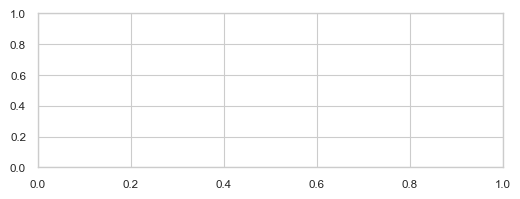

In [11]:
i = 239
gymid = msdata['IDENTIFIER'][i]
spec = dataset[i][SPECTRUM].T
spec = su.unpad_peak_list(spec)

with open(f'../../data/trees_with_test_split/{gymid}.json', 'r') as f:
    G = parse_fragmentation_tree(json.load(f))

num_expl_peaks = float(G.graph['annotations']['statistics']['ratioOfExplainedPeaks'])

max_attention = get_max_attn(i)
edge_attn_df = construct_edge_attn_df(G, i, max_attention)

su.plot_spectrum(spec, hue=max_attention.max(axis=0), normalize_intensities=False)

su.plot_spectrum(
    spec,
    hue=[(m in edge_attn_df['mapped_source_mz'].values or m in edge_attn_df['mapped_target_mz'].values) for m in spec[0]], 
    normalize_intensities=False
)

# Plot the max attention matrix
labels = [f'{p[0]:.2f}, {p[1]:.2f}' for p in spec.T if p[0] != 0]
plt.figure(figsize=(6, 4))

# Plot the heatmap with highlighted edges
sns.heatmap(max_attention, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title('Max Attention Across All Heads and Layers')
plt.xlabel('Target Peaks')
plt.ylabel('Source Peaks')

plt.tight_layout()
plt.show()

plot_tree(G)

In [635]:
# attn_i = get_attn(i)
# # Plot matrices
# for l in range(len(attn_i)):
#     print(l)
#     num_heads = attn_i.shape[1]
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#     axes = axes.flatten()
    
#     for h in range(num_heads):
#         ax = axes[h]
#         sns.heatmap(attn_i[l][h], xticklabels=labels, yticklabels=labels, cmap='viridis', ax=ax)
#         ax.set_title(f'Layer {l}, Head {h}')
#         ax.set_xlabel('Target Peaks')
#         ax.set_ylabel('Source Peaks')
    
#     plt.tight_layout()
#     plt.show()

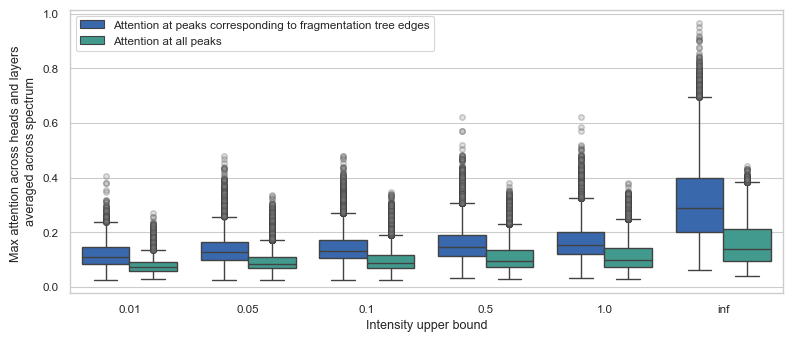


Intensity threshold: 0.01
Number of spectra: 2968
Mean Edge Attention - Mean: 0.1194, Median: 0.1105
Mean Overall Attention - Mean: 0.0792, Median: 0.0721
Mann-Whitney U test - statistic: 6884443.0000, p-value: 8.0351e-309
SIGNIFICANT: Edge attention is significantly HIGHER than overall attention

Intensity threshold: 0.05
Number of spectra: 23632
Mean Edge Attention - Mean: 0.1364, Median: 0.1268
Mean Overall Attention - Mean: 0.0936, Median: 0.0846
Mann-Whitney U test - statistic: 434800224.0000, p-value: 0.0000e+00
SIGNIFICANT: Edge attention is significantly HIGHER than overall attention

Intensity threshold: 0.1
Number of spectra: 32507
Mean Edge Attention - Mean: 0.1427, Median: 0.1324
Mean Overall Attention - Mean: 0.0988, Median: 0.0886
Mann-Whitney U test - statistic: 812801665.0000, p-value: 0.0000e+00
SIGNIFICANT: Edge attention is significantly HIGHER than overall attention

Intensity threshold: 0.5
Number of spectra: 44776
Mean Edge Attention - Mean: 0.1575, Median: 0.145

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

# Prepare data for plotting
plot_data = []
for intensity_thld, df_res in dfs_res.items():
    for _, row in df_res.iterrows():
        plot_data.append({
            'Intensity upper bound': intensity_thld,
            'Attention at peaks corresponding to fragmentation tree edges': row['mean_edge_attn'],
            'Attention at all peaks': row['mean_overall_attn']
        })

# Create DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = pd.melt(plot_df, 
                         id_vars=['Intensity upper bound'],
                         value_vars=['Attention at peaks corresponding to fragmentation tree edges', 'Attention at all peaks'],
                         var_name='Attention Type', value_name='Attention Value')

# Create the plot
plots.init_plotting(figsize=(8, 3.5), cmap='nature')  # Increased size to accommodate box plots

# Create box plots with lower alpha for outliers
sns.boxplot(x='Intensity upper bound', y='Attention Value', hue='Attention Type', data=plot_df_melted, flierprops=dict(markerfacecolor='0.5', markersize=4, alpha=0.25))

# Customize the plot
plt.xlabel('Intensity upper bound')
plt.ylabel('Max attention across heads and layers \naveraged across spectrum')

# Move legend outside the plot
plt.legend(title='')

plt.tight_layout()
plots.save_fig('max_attention_boxplot.png', dpi=500)
plt.show()

# Print summary statistics and Mann-Whitney U test results
for intensity_thld, df_res in dfs_res.items():
    print(f"\nIntensity threshold: {intensity_thld}")
    print(f"Number of spectra: {len(df_res)}")
    print(f"Mean Edge Attention - Mean: {df_res['mean_edge_attn'].mean():.4f}, Median: {df_res['mean_edge_attn'].median():.4f}")
    print(f"Mean Overall Attention - Mean: {df_res['mean_overall_attn'].mean():.4f}, Median: {df_res['mean_overall_attn'].median():.4f}")
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(
        df_res['mean_edge_attn'],
        df_res['mean_overall_attn'],
        alternative='two-sided'
    )
    print(f"Mann-Whitney U test - statistic: {statistic:.4f}, p-value: {p_value:.4e}")
    
    # Print significance result
    alpha = 0.05
    if p_value < alpha:
        if df_res['mean_edge_attn'].median() > df_res['mean_overall_attn'].median():
            print("SIGNIFICANT: Edge attention is significantly HIGHER than overall attention")
        else:
            print("SIGNIFICANT: Edge attention is significantly LOWER than overall attention")
    else:
        print("No significant difference between edge and overall attention")

In [51]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Prepare data for plotting
# plot_data = []
# for intensity_thld, df_res in dfs_res.items():
#     num_spectra = len(df_res)
#     prop_significant = (df_res['p_value'] < 0.05).sum() / num_spectra
#     prop_edge_gt_overall = (df_res['mean_edge_attn'] > df_res['mean_overall_attn']).sum() / num_spectra
#     plot_data.append({
#         'Intensity Threshold': intensity_thld,
#         'Number of Spectra': num_spectra,
#         'Proportion of Significant p-values': prop_significant,
#         'Proportion of Edge > Overall Attention': prop_edge_gt_overall
#     })

# # Create DataFrame for plotting
# plot_df = pd.DataFrame(plot_data)

# # Melt the DataFrame for easier plotting with seaborn
# plot_df_melted = pd.melt(plot_df, 
#                          id_vars=['Intensity Threshold', 'Number of Spectra'],
#                          value_vars=['Proportion of Significant p-values', 'Proportion of Edge > Overall Attention'],
#                          var_name='Metric', value_name='Proportion')

# # Create the plot
# plots.init_plotting(figsize=(8, 3))  # Increased size to accommodate both lines and bars

# # Add bar plot
# sns.barplot(x='Intensity Threshold', y='Proportion', hue='Metric', data=plot_df_melted,
#             alpha=0.5)

# # Add line plot with markers
# sns.pointplot(x='Intensity Threshold', y='Proportion', hue='Metric', data=plot_df_melted,
#               markers=['o', 's'], linestyles=['-', '--'], linewidth=1, dodge=0.4, markersize=5)

# # Customize the plot
# plt.title('Comparison of Metrics across Intensity Thresholds')
# plt.xlabel('Intensity Threshold')
# plt.ylabel('Proportion')
# plt.ylim(0, 1.05)

# # Move legend outside the plot
# plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

# # Print the data
# for intensity_thld, df_res in dfs_res.items():
#     print(f"Number of spectra: {len(df_res)}")
#     print(f"Intensity threshold: {intensity_thld}")
#     print(f"Proportion of significant p-values: {(df_res['p_value'] < 0.05).sum() / len(df_res):.4f}")
#     print(f"Proportion of cases where mean edge attention > mean overall attention: {(df_res['mean_edge_attn'] > df_res['mean_overall_attn']).sum() / len(df_res):.4f}")
#     print()

In [461]:
edge_attn_df

,source_node,target_node,source_mz,target_mz,mapped_source_mz,mapped_target_mz,source_intensity,target_intensity,max_attention
0,0,1,363.0229,334.9902,363.021790,334.990204,1.100000,0.050050,0.836289
1,1,2,334.9902,306.9598,334.990204,306.959808,0.050050,0.112112,0.236240
2,2,3,306.9598,288.9491,306.959808,288.949097,0.112112,0.214214,0.405815
3,2,4,306.9598,272.9714,306.959808,272.971405,0.112112,0.042042,0.133543
4,2,7,306.9598,226.9934,306.959808,226.993393,0.112112,1.000000,0.463945
5,2,10,306.9598,211.0157,306.959808,211.015701,0.112112,0.201201,0.116140
6,3,5,288.9491,270.9379,288.949097,270.937897,0.214214,0.015015,0.128898
7,3,6,288.9491,256.9770,288.949097,256.976990,0.214214,0.014014,0.110621
8,3,9,288.9491,224.9768,288.949097,224.976807,0.214214,0.019019,0.111331
9,4,11,272.9714,208.9993,272.971405,208.999298,0.042042,0.010010,0.127864


In [387]:
print((df_res['p_value'] < 0.05).sum(), len(df_res))
print((df_res['mean_edge_attn'] > df_res['mean_overall_attn']).sum(), len(df_res))

11 22
22 22


In [325]:
print((df_res['p_value'] < 0.05).sum(), len(df_res))
print((df_res['mean_edge_attn'] > df_res['mean_overall_attn']).sum(), len(df_res))

474 756
716 756


In [322]:
print((df_res['p_value'] < 0.05).sum(), len(df_res))
print((df_res['mean_edge_attn'] > df_res['mean_overall_attn']).sum(), len(df_res))

447 627
607 627


In [327]:
df_res['mean_diff'] = df_res['mean_edge_attn'] - df_res['mean_overall_attn']

In [286]:
# spec = dataset[i][SPECTRUM].T
# prec_mz = dataset[i][PRECURSOR_MZ]
# n_peaks = (spec[0] != 0).sum()
# labels = [f'{p[0]:.2f}, {p[1]:.2f}' for p in spec.T][:n_peaks]
# attn_i = [attns[l][i, :, :n_peaks, :n_peaks].unsqueeze(0) for l in attns.keys()]
# print(attn_i[0].shape, len(labels))
# # head_view(attn_i, labels)

# total_attn = []
# for j in range(n_peaks):
#     total_attn.append(max(attn_i[l][0, :, :, j].max() for l in range(len(attn_i))).item())

# su.plot_spectrum(spec, hue=total_attn, normalize_intensities=False)

In [287]:
# spec.T.tolist()

In [288]:
# import matplotlib.pyplot as plt
# import numpy as np
# from dreams.utils.plots import init_plotting
# init_plotting(figsize=(8, 6))

# # Calculate max attention across all heads and layers
# max_attention = np.zeros((n_peaks, n_peaks))
# for l in attns.keys():
#     for h in range(attns[l].shape[1]):
#         max_attention = np.maximum(max_attention, attns[l][i, h, :n_peaks, :n_peaks].detach().numpy())

# # Plot the max attention matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(max_attention, xticklabels=labels, yticklabels=labels, cmap='viridis')
# plt.title('Max Attention Across All Heads and Layers')
# plt.xlabel('Target Peaks')
# plt.ylabel('Source Peaks')
# plt.tight_layout()
# plt.show()